In [51]:
# https://timesofindia.indiatimes.com/city/bengaluru/70-apartments-in-city-dont-get-cauvery-water/articleshow/70031682.cms
#

In [52]:
!pip install pyrsgis

In [53]:
import os, math, numpy as np
from pyrsgis import raster, convert
from osgeo import gdal
from google.colab import drive
from copy import deepcopy
from skimage.metrics import structural_similarity as ssim
import random
from matplotlib import pyplot as plt

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
f2020 = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/Sentinel_Bangalore_2020.tif"
pop2020 = "/content/drive/MyDrive/Capstone_Data/Population_data/2020.tif"
pop2030 = "/content/drive/MyDrive/Capstone_Data/Population_data/2030.tif"
water_pipeline = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/waterWays.tif"
road = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/road.tif"

f20220 = "/content/drive/MyDrive/Capstone_Data/water/2020.tif"
f2030 = "/content/drive/MyDrive/Capstone_Data/water/predicted_2030.tif"

ds1,arr2020 = raster.read(f2020,bands=1)
pop_ds_2020, pop_arr_2020 = raster.read(pop2020,bands=1)
pop_ds_2030, pop_arr_2030 = raster.read(pop2030,bands=1)
water_ds, water_arr = raster.read(water_pipeline,bands=1)
road_ds, road_arr = raster.read(road, bands=1)

ds2,arr20220 = raster.read(f20220,bands=1)
ds3,arr2030 = raster.read(f2030,bands=1)

no_rows = ds1.RasterYSize
no_cols = ds1.RasterXSize

In [56]:
arr20220[arr20220==1] =3
arr20220[arr20220==4] =2
arr20220[arr20220==5]=4
arr20220[arr20220==7]=1
arr20220[arr20220==8]=4
arr20220[arr20220==11]=2

In [101]:
scaling_factors = [sum(arr2030[800:1200,700:1100][arr2030[800:1200,700:1100]==1])/sum(arr20220[800:1200,700:1100][arr20220[800:1200,700:1100]==1]),
                   sum(arr2030[100:450, 550:900][arr2030[100:450, 550:900]==1])/sum(arr20220[100:450, 550:900][arr20220[100:450, 550:900]==1]),
                   sum(arr2030[700:1000, 400:700][arr2030[700:1000, 400:700]==1])/sum(arr20220[700:1000, 400:700][arr20220[700:1000, 400:700]==1]),
                   sum(arr2030[0:300, 0:300][arr2030[0:300, 0:300]==1])/sum(arr20220[0:300, 0:300][arr20220[0:300, 0:300]==1])]
scaling_factors

[1.309862953247199, 1.44372668546993, 1.2012610770279482, 1.1421924819026505]

In [58]:
# scaling_factor = 1.345
pixel_size = 30 # 30x30 meters per pixel
water_per_person = 150 #100 - 150L of water per person per day given by BWSSB

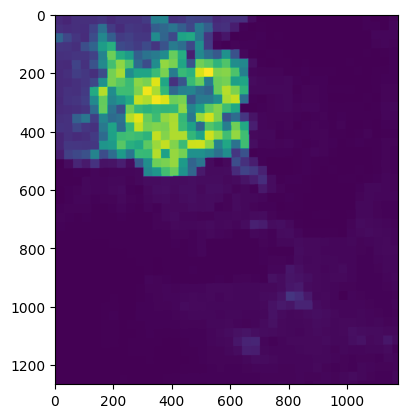

In [59]:
plt.imshow(pop_arr_2020)

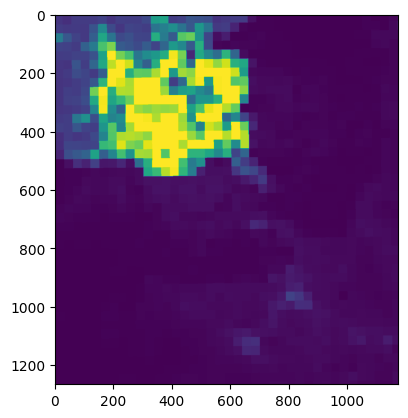

In [60]:
plt.imshow(pop_arr_2030)

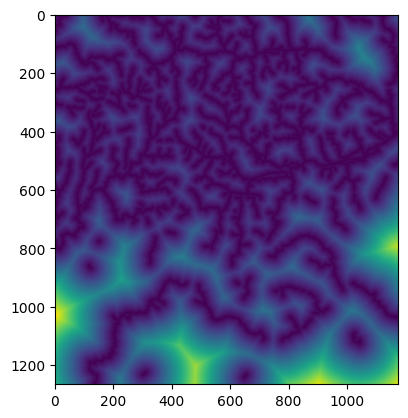

In [61]:
plt.imshow(water_arr)

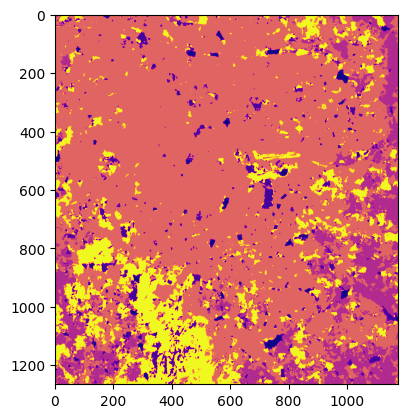

In [62]:
plt.imshow(arr2020, cmap="plasma")

# Bommasandra and Surrounding Regions



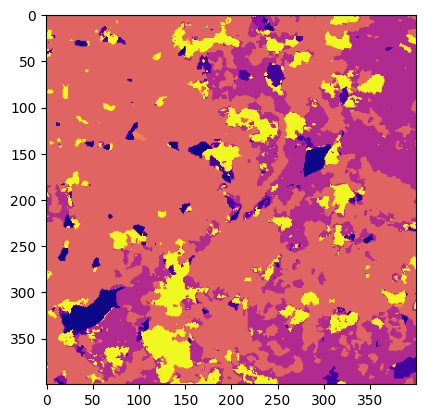

In [63]:
plt.imshow(arr2020[800:1200,700:1100], cmap='plasma')

In [64]:
# This is the region including and surrounding Bommansandra layout.
pop_bom_2020 = pop_arr_2020[800:1200,700:1100]
pop_bom_2030 = pop_arr_2030[800:1200,700:1100]
bom_2020 = arr2020[800:1200,700:1100]

In [100]:
growth_pop = sum(np.unique(pop_bom_2020))*scaling_factors[0]
growth_pop

458320.1896224026

In [66]:
water_bom = water_arr[800:1200,700:1100]
pipe_bom_300 = sum(sum(water_bom==0))*pixel_size
print(pipe_bom_300)

28230


In [67]:
req_water = growth_pop*water_per_person
req_water

68748028.44336039

In [68]:
present_water = sum(np.unique(pop_bom_2020))*water_per_person
present_water

52484901.777648926

In [69]:
# Current and future water supply in liters per day
current_water_supply = present_water  # liters per day
future_water_demand = req_water  # liters per day

# Conversion factor: 1 cubic meter = 1000 liters
# Convert liters per day to cubic meters per day
current_water_supply_cubic_meters = current_water_supply / 1000  # cubic meters per day
future_water_demand_cubic_meters = future_water_demand / 1000  # cubic meters per day

# Convert cubic meters per day to cubic meters per second
seconds_per_day = 24 * 60 * 60
current_flow_rate = current_water_supply_cubic_meters / seconds_per_day  # cubic meters per second
future_flow_rate = future_water_demand_cubic_meters / seconds_per_day  # cubic meters per second

current_flow_rate, future_flow_rate

(0.6074641409450108, 0.7956947736500044)

In [70]:
# Current pipeline diameter in meters (300 mm)
current_diameter = 0.3  # in meters

# Calculate the area of the current pipeline (A = π * r^2)
current_area = math.pi * (current_diameter / 2) ** 2

# Calculate the velocity of water in the current pipeline (v = Q / A)
current_velocity = current_flow_rate / current_area

# Using the future flow rate and the current velocity, calculate the required area for the future pipeline (A = Q / v)
future_area = future_flow_rate / current_velocity

# Calculate the required diameter from the future area (d = 2 * sqrt(A / π))
future_diameter = 2 * math.sqrt(future_area / math.pi)

current_velocity, future_diameter

(8.593859625108468, 0.34334773305243754)

In [71]:
#Electricity per capita in the region as given by BESCOM
req_ele = 4000

present_electricity_demand = sum(np.unique(pop_bom_2020))*req_ele

print(present_electricity_demand)

growth_pop = sum(np.unique(pop_bom_2020))*scaling_factors[0]

future_electricity_demand = growth_pop*req_ele

print(future_electricity_demand)

1399597380.7373047
1833280758.4896104


# Banswadi, Mahadevapura, Ramamurthy Nagar

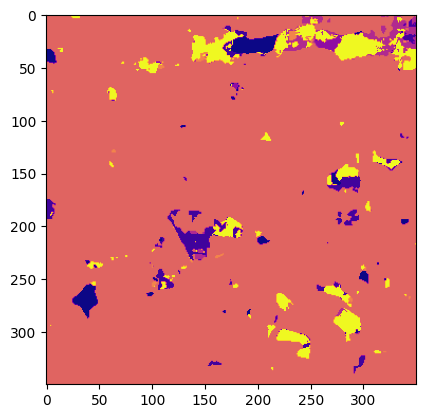

In [72]:
#This is the region inclunding banswadi, mahadevapura, ramamurthy nagar
plt.imshow(arr2020[100:450, 550:900], cmap="plasma")

In [102]:
pop_banas_2020 = pop_arr_2020[100:450, 550:900]
pop_banas_2030 = pop_arr_2030[100:450, 550:900]
banas_2020 = arr2020[100:450, 550:900]

In [103]:
growth_pop_banas = sum(np.unique(pop_banas_2020))*scaling_factors[1]

In [104]:
water_banas = water_arr[100:450, 550:900]
pipe_banas_300 = sum(sum(water_banas==0))*pixel_size
print(pipe_banas_300)

96810


In [105]:
req_water = growth_pop_banas*water_per_person
req_water

391142940.1926511

In [106]:
present_water = sum(np.unique(pop_banas_2020))*water_per_person
present_water

270925892.0883179

In [107]:
# Current and future water supply in liters per day
current_water_supply = present_water  # liters per day
future_water_demand = req_water  # liters per day

# Conversion factor: 1 cubic meter = 1000 liters
# Convert liters per day to cubic meters per day
current_water_supply_cubic_meters = current_water_supply / 1000  # cubic meters per day
future_water_demand_cubic_meters = future_water_demand / 1000  # cubic meters per day

# Convert cubic meters per day to cubic meters per second
seconds_per_day = 24 * 60 * 60
current_flow_rate = current_water_supply_cubic_meters / seconds_per_day  # cubic meters per second
future_flow_rate = future_water_demand_cubic_meters / seconds_per_day  # cubic meters per second

current_flow_rate, future_flow_rate


(3.1357163436147903, 4.527117363340869)

In [108]:
# Current pipeline diameter in meters (300 mm)
current_diameter = 0.3  # in meters

# Calculate the area of the current pipeline (A = π * r^2)
current_area = math.pi * (current_diameter / 2) ** 2

# Calculate the velocity of water in the current pipeline (v = Q / A)
current_velocity = current_flow_rate / current_area

# Using the future flow rate and the current velocity, calculate the required area for the future pipeline (A = Q / v)
future_area = future_flow_rate / current_velocity

# Calculate the required diameter from the future area (d = 2 * sqrt(A / π))
future_diameter = 2 * math.sqrt(future_area / math.pi)

current_velocity, future_diameter

(44.361311664030055, 0.3604655346802155)

In [80]:
#Electricity per capita in the region as given by BESCOM
req_ele = 2000

present_electricity_demand = sum(np.unique(pop_banas_2020))*req_ele

print(present_electricity_demand)

future_electricity_demand = growth_pop_banas*req_ele

print(future_electricity_demand)

3612345227.8442383
3770301111.4309855




```
```

## Kothnur, Hulimavu and Chandrasekarapura - phase 4


In [81]:
# https://www.indiatoday.in/cities/bengaluru/story/bengaluru-losing-1-million-litres-of-water-per-day-due-to-cauvery-pipeline-leakage-1820444-2021-06-28
#TK HALLI WATER TREAMENT PLANT

In [82]:
#Kothanur Dinne
pop_area3_2020 = pop_arr_2020[700:1000, 400:700]
pop_area3_2030 = pop_arr_2030[700:1000, 400:700]
area3_2020 = arr2020[700:1000, 400:700]

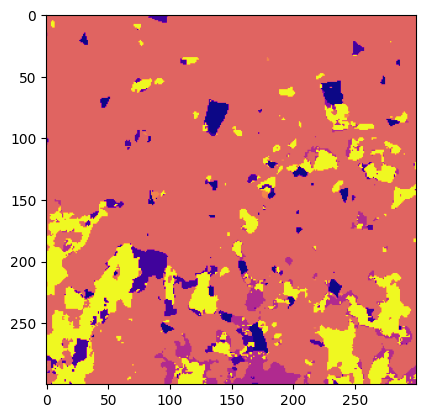

In [83]:
plt.imshow(area3_2020, cmap='plasma')

In [84]:
growth_pop = sum(np.unique(pop_area3_2020))*scaling_factors[2]

In [85]:
water_area3 = water_arr[700:1000, 400:700]
pipe_area3_300 = sum(sum(water_area3==0))*pixel_size
print(pipe_area3_300)

21780


In [86]:
req_water = growth_pop*water_per_person
req_water

23434641.48034796

In [87]:
present_water = sum(np.unique(pop_area3_2020))*water_per_person
present_water

19508366.606140137

In [88]:
# Current and future water supply in liters per day
current_water_supply = present_water  # liters per day
future_water_demand = req_water  # liters per day

# Conversion factor: 1 cubic meter = 1000 liters
# Convert liters per day to cubic meters per day
current_water_supply_cubic_meters = current_water_supply / 1000  # cubic meters per day
future_water_demand_cubic_meters = future_water_demand / 1000  # cubic meters per day

# Convert cubic meters per day to cubic meters per second
seconds_per_day = 24 * 60 * 60
current_flow_rate = current_water_supply_cubic_meters / seconds_per_day  # cubic meters per second
future_flow_rate = future_water_demand_cubic_meters / seconds_per_day  # cubic meters per second

current_flow_rate, future_flow_rate

(0.22579128016365901, 0.2712342763929162)

In [89]:
# Current pipeline diameter in meters (300 mm)
current_diameter = 0.3  # in meters

# Calculate the area of the current pipeline (A = π * r^2)
current_area = math.pi * (current_diameter / 2) ** 2

# Calculate the velocity of water in the current pipeline (v = Q / A)
current_velocity = current_flow_rate / current_area

# Using the future flow rate and the current velocity, calculate the required area for the future pipeline (A = Q / v)
future_area = future_flow_rate / current_velocity

# Calculate the required diameter from the future area (d = 2 * sqrt(A / π))
future_diameter = 2 * math.sqrt(future_area / math.pi)

current_velocity, future_diameter

(3.1942931862305195, 0.32880616924339384)

In [90]:
#Electricity per capita in the region as given by BESCOM
req_ele = 1000

present_electricity_demand = sum(np.unique(pop_area3_2020))*req_ele

print(present_electricity_demand)

future_electricity_demand = sum(np.unique(pop_area3_2020))*scaling_factors[2]*req_ele

print(future_electricity_demand)

130055777.37426758
156230943.20231974





## Nagasandra - phase 4

In [91]:
pop_area4_2020 = pop_arr_2020[0:300, 0:300]
pop_area4_2030 = pop_arr_2030[0:300, 0:300]
area4_2020 = arr2020[0:300, 0:300]

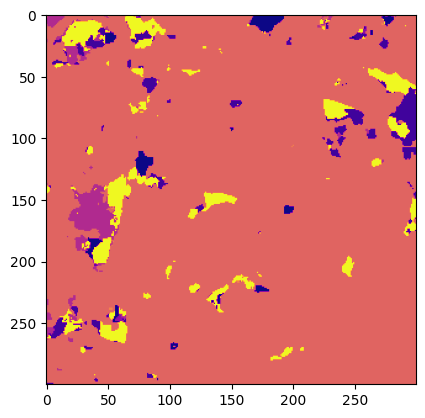

In [92]:
plt.imshow(area4_2020, cmap="plasma")

In [93]:
growth_pop = sum(np.unique(pop_area4_2020))*scaling_factors[3]

In [94]:
water_area4 = water_arr[0:300, 0:300]
pipe_area4_300 = sum(sum(water_area4==0))*pixel_size
print(pipe_area4_300)

54150


In [95]:
req_water = growth_pop*water_per_person
req_water

417204698.7954232

In [96]:
present_water = sum(np.unique(pop_area4_2020))*water_per_person
present_water

365266542.55371094

In [97]:
# Current and future water supply in liters per day
current_water_supply = present_water  # liters per day
future_water_demand = req_water  # liters per day

# Conversion factor: 1 cubic meter = 1000 liters
# Convert liters per day to cubic meters per day
current_water_supply_cubic_meters = current_water_supply / 1000  # cubic meters per day
future_water_demand_cubic_meters = future_water_demand / 1000  # cubic meters per day

# Convert cubic meters per day to cubic meters per second
seconds_per_day = 24 * 60 * 60
current_flow_rate = current_water_supply_cubic_meters / seconds_per_day  # cubic meters per second
future_flow_rate = future_water_demand_cubic_meters / seconds_per_day  # cubic meters per second

current_flow_rate, future_flow_rate

(4.22762202029758, 4.828758087909991)

In [98]:
# Current pipeline diameter in meters (300 mm)
current_diameter = 0.3  # in meters

# Calculate the area of the current pipeline (A = π * r^2)
current_area = math.pi * (current_diameter / 2) ** 2

# Calculate the velocity of water in the current pipeline (v = Q / A)
current_velocity = current_flow_rate / current_area

# Using the future flow rate and the current velocity, calculate the required area for the future pipeline (A = Q / v)
future_area = future_flow_rate / current_velocity

# Calculate the required diameter from the future area (d = 2 * sqrt(A / π))
future_diameter = 2 * math.sqrt(future_area / math.pi)

current_velocity, future_diameter

(59.80861707151155, 0.32062021672258684)

In [99]:
#Electricity per capita in the region as given by BESCOM
req_ele = 3000

present_electricity_demand = sum(np.unique(pop_area4_2020))*req_ele

print(present_electricity_demand)

future_electricity_demand = growth_pop*req_ele

print(future_electricity_demand)

7305330851.074219
8344093975.9084635
